In [1]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [2]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4047/jobs/


In [3]:
import axs
catalog = axs.AxsCatalog(spark)
wtf = catalog.load("stevengs_cut_wtf")

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from windowing import around_window_udf
from spark_curve_fit import *
from fit_utils import *

In [5]:
_x = wtf['mjd_r']
_y = wtf['mag_r']
_yerr = wtf['magerr_r']
_start = wtf['dip.start_mjd']
_end = wtf['dip.end_mjd']
wiggle = 4.0

_df = wtf.withColumn(
    "window",
    around_window_udf(wiggle=wiggle)(_x, _y, _yerr, _start, _end)
).select(
    "mjd_r",
    "mag_r",
    "magerr_r",
    "dip",
    "window"
)

In [6]:
def top_hat(x, loc, width, depth, offset):
    import numpy as np
    x = np.array(x)
    left = loc - width / 2
    right = loc + width / 2
    outside = (x < left) | (x > right)
    inside = np.logical_not(outside)
    
    y = np.zeros(x.shape)
    y[outside] = offset
    y[inside] = offset + depth
    
    return y

def top_hat_p0(x, y, yerr, dip_start, dip_end, dip_integral) -> ArrayType(FloatType()):
    import numpy as np
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    
    in_dip_window = (x > dip_start) & (x < dip_end)
    y_in_window  = y[in_dip_window]
    
    if len(y_in_window) > 0:
        offset = float(np.median(y))
        depth = float(dip_integral)
        loc = float((dip_end + dip_start) / 2)
        width = float(dip_end - dip_start)
    else:
        offset = 1.
        depth = 1.
        loc = 1.
        width = 1.
    
    return [loc, width, depth, offset]

top_hat_p0_udf = make_udf_from_annotated_function(top_hat_p0)

In [108]:
top_hat_p0_col = top_hat_p0_udf(
    wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], 
    wtf['dip']['start_mjd'], wtf['dip']['end_mjd'], wtf['dip']['integral']
)

top_hat_fit_df = fit_band_around_dip(wtf, top_hat, "r", 4.0, p0=top_hat_p0_col)
top_hat_fit_df = evaluate_in_dip(top_hat_fit_df, top_hat, "r")

In [27]:
def skew_normal(x, skew, loc, xscale, yscale, offset):
    from scipy.stats import skewnorm
    _dist = skewnorm(skew, loc=loc, scale=xscale)
    return yscale * _dist.pdf(x) + offset

from pyspark.sql.types import ArrayType, FloatType
def skew_normal_p0(x, y, yerr, dip_start, dip_end, dip_integral) -> ArrayType(FloatType()):
    import numpy as np
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    
    in_dip_window = (x > dip_start) & (x < dip_end)
    y_in_window  = y[in_dip_window]
    
    if len(y_in_window) > 0:
        offset = float(np.median(y))
        yscale = float(dip_integral)
        loc = float((dip_end + dip_start) / 2)
        xscale = float(dip_end - dip_start)
        skew = 0.0
    else:
#         raise RuntimeError("no measurements in window")
        offset = 1.
        yscale = 1.
        loc = 1.
        xscale = 1.
        skew = 0.

    
    return [skew, loc, xscale, yscale, offset]

skew_normal_p0_udf = make_udf_from_annotated_function(skew_normal_p0)

In [109]:
skew_norm_p0_col = skew_normal_p0_udf(
    wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], 
    wtf['dip']['start_mjd'], wtf['dip']['end_mjd'], wtf['dip']['integral']
)

skew_norm_fit_df = fit_band_around_dip(wtf, skew_normal, "r", 2.0, p0=skew_norm_p0_col)
skew_norm_fit_df = evaluate_in_dip(skew_norm_fit_df, skew_normal, "r")

In [57]:
_lc = skew_norm_fit_df.head(10)

In [145]:
skew_normal_fits = catalog.load("stevengs_skew_normal_fits_r_band")
_x = skew_normal_fits['window_r']['x']
_y = skew_normal_fits['window_r']['y']
_yerr = skew_normal_fits['window_r']['yerr']
_popt = skew_normal_fits['fit_r']['popt']
skew_normal_fits = skew_normal_fits.withColumn(
    "model_error_in_window_r",
    evaluate_model_error_udf(skew_normal)(_x, _y, _yerr, _popt)
)

In [148]:
fits_df = skew_normal_fits.where(
    skew_normal_fits['fit_r.info.good']
).select(
    "fit_r", "fit_r.popt", "model_error_in_dip_r", "model_error_in_window_r"
).toPandas()

In [159]:
fits_df['model_error_in_window_r']

0         (402.0196228027344, 1.675081729888916)
1         (932.617919921875, 5.2690277099609375)
2         (799.7885131835938, 4.544252872467041)
3         (735.026611328125, 3.8890295028686523)
4          (810.594970703125, 9.107809066772461)
                          ...                   
64644       (140.4990234375, 2.1287732124328613)
64645     (238.0046844482422, 2.587007522583008)
64646    (332.5982666015625, 1.0018019676208496)
64647     (2646.975341796875, 32.28018569946289)
64648       (4006.92138671875, 31.0614070892334)
Name: model_error_in_window_r, Length: 64649, dtype: object

In [169]:
fits_df['model_error_in_dip_r'].index

RangeIndex(start=0, stop=64649, step=1)

In [326]:
_popts_pd = pd.DataFrame(fits_df['popt'].to_list(), columns=['skew', 'loc', 'xscale', 'yscale', 'offset'])
_error_dip_pd = pd.DataFrame(fits_df['model_error_in_dip_r'].to_list(), columns=['dip_sse', 'dip_reduced_sse'])
_error_window_pd = pd.DataFrame(fits_df['model_error_in_window_r'].to_list(), columns=['window_sse', 'window_reduced_sse'])
fits_pd = _popts_pd.join(_error_dip_pd).join(_error_window_pd)
fits_pd
# _error_window_pd

,skew,loc,xscale,yscale,offset,dip_sse,dip_reduced_sse,window_sse,window_reduced_sse
0,-46257.921875,892793.375000,71.597153,1.474692,14.181811,247.902100,1.073169,402.019623,1.675082
1,-442.198578,58662.289062,3.654379,0.978375,19.289171,801.748779,5.172573,932.617920,5.269028
2,4.428215,58657.085938,89.075760,20.822546,18.378359,666.178528,4.382753,799.788513,4.544253
3,-0.979013,58670.382812,10.578972,9.821786,19.855080,286.486023,2.628312,735.026611,3.889030
4,-0.879353,58615.558594,16.374544,-17.123798,19.986097,804.081604,10.051020,810.594971,9.107809
...,...,...,...,...,...,...,...,...,...
64644,0.234976,58463.097656,39.416439,1.397476,17.399681,45.603729,1.824149,140.499023,2.128773
64645,-1417.786255,65622.000000,2.688289,-0.248893,16.071712,17.915619,1.791562,238.004684,2.587008
64646,0.037688,58775.785156,0.493223,0.044736,16.535181,307.439178,0.979106,332.598267,1.001802
64647,-0.124365,58269.660156,0.861884,0.043276,13.630946,26.500139,3.312517,2646.975342,32.280186


In [183]:
(_error_dip_pd.join(_error_window_pd).replace([np.inf, -np.inf], np.nan).fillna(-1))

,dip_sse,dip_reduced_sse,window_sse,window_reduced_sse
0,247.902100,1.073169,402.019623,1.675082
1,801.748779,5.172573,932.617920,5.269028
2,666.178528,4.382753,799.788513,4.544253
3,286.486023,2.628312,735.026611,3.889030
4,804.081604,10.051020,810.594971,9.107809
...,...,...,...,...
64644,45.603729,1.824149,140.499023,2.128773
64645,17.915619,1.791562,238.004684,2.587008
64646,307.439178,0.979106,332.598267,1.001802
64647,26.500139,3.312517,2646.975342,32.280186


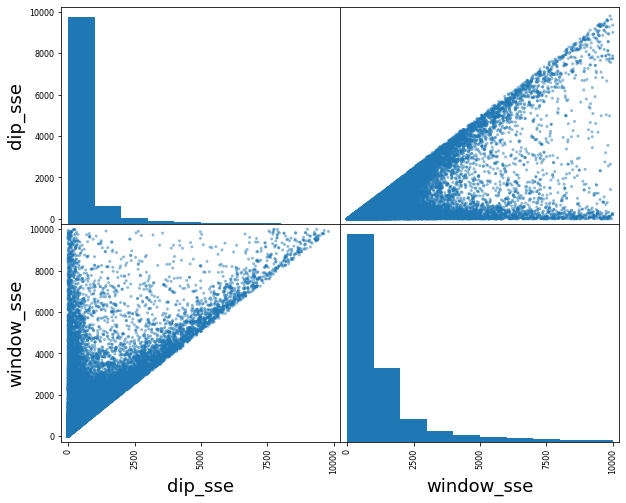

In [214]:
from pandas.plotting import scatter_matrix
plt.rc("font", size=18)
plt.rc("figure", figsize=[10, 8])
_df = _error_dip_pd.join(
    _error_window_pd
).replace(
    [np.inf, -np.inf], np.nan
).fillna(
    -1
).drop(
    "dip_reduced_sse", 1
).drop(
    "window_reduced_sse", 1
)
scatter_matrix(_df[
    (_df > 0) &
    (_df < 1e4)
])
plt.show()

In [123]:
plot_pd = popts_pd.drop("offset", 1).drop("loc", 1)
plot_pd['sse'] = error_pd['sse']

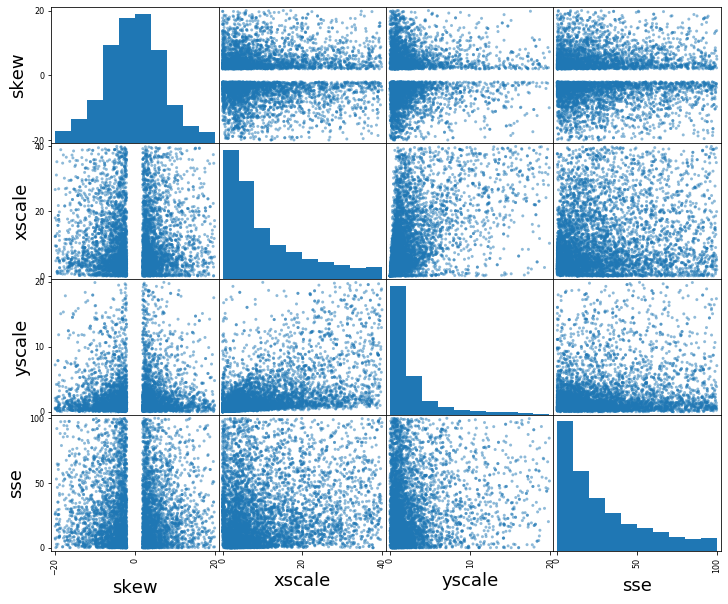

In [327]:
from pandas.plotting import scatter_matrix
plt.rc("font", size=18)
plt.rc("figure", figsize=[12, 10])
scatter_matrix(plot_pd[
    (plot_pd['sse'] < 100) & 
    ((
        (plot_pd['skew'] > -20) & 
        (plot_pd['skew'] < -2)
    ) |
    (
        (plot_pd['skew'] > 2) &  
        (plot_pd['skew'] < 20)
    )) &
    (plot_pd['yscale'] < 20) &
    (plot_pd['yscale'] > 0)  &
    (plot_pd['xscale'] < 40)
])
plt.show()
# plt.hist2d(popts_pd['width'], popts_pd['offset'])
# plt.show()

In [58]:
_lc[0]['fit_r']

Row(info=Row(message='OK', good=True, runtime=0.320939302444458), popt=[4.729416370391846, 58324.79296875, 16.83372688293457, 2.5094034671783447, 14.181524276733398], pcov=[[1.033334771679232e+17, -220682600316928.0, 7210614434824192.0, -4215647839977472.0, -402.0959167480469], [-221331543031808.0, 442663086063616.0, 84325424955392.0, 7248134275072.0, 806.65234375], [3.87439379045417e+16, -42653353771008.0, -1.6746092519489536e+16, -4185190079397888.0, -77.68309020996094], [4889837043712.0, -9779674087424.0, -2606273128300544.0, -348742318292992.0, -17.81989097595215], [-403.3262023925781, 806.6524047851562, 153.66375732421875, 13.208051681518555, 3.518031519433862e-07]], p0=[0.0, 58282.40234375, 22.609375, 0.730926513671875, 14.178905487060547])

In [201]:
def plot_model(x, model, model_params, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt
        
    # plot model
    min_x = np.min(x)
    max_x = np.max(x)
    _x = np.linspace(min_x, max_x, 10000)
    _y = model(_x, *model_params)    
    plt.plot(_x, _y, **kwargs)

def plot_data(x, y, yerr, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # plot data
    plt.errorbar(x, y, yerr=yerr, fmt="o", **kwargs)
    
def plot_fit_result(x, y, yerr, fit, model, with_p0=False):
    plot_data(x, y, yerr, color="C0", label="data")
    plot_model(x, model, fit['popt'], lw=3, color="C1", label="popt")
    if with_p0:
        plot_model(x, model, fit['p0'], lw=3, color="C1", ls='--', label="p0")
    plt.legend()

In [331]:
fits_to_show = skew_normal_fits.where(
    (skew_normal_fits['fit_r.info.good']) &
    (skew_normal_fits['model_error_in_window_r.reduced_sum_square_error'] < 5) &  
    (
        (skew_normal_fits['fit_r.popt'][0] > 2) | (skew_normal_fits['fit_r.popt'][0] < -2)
    )
).sort(
    skew_normal_fits['dip.significance'],
    ascending=False
)

In [332]:
_lc = fits_to_show.collect()

In [334]:
len(_lc)

27979

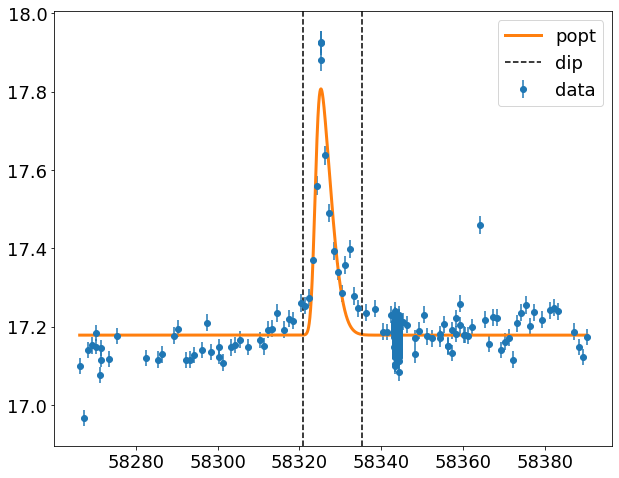

In [333]:
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=18)

i = 1

window_x = _lc[i]['window_r']['x']
window_y = _lc[i]['window_r']['y']
window_yerr = _lc[i]['window_r']['yerr']

start = _lc[i]['dip']['start_mjd']
end = _lc[i]['dip']['end_mjd']

x = _lc[i]['mjd_r']
y = _lc[i]['mag_r']
yerr = _lc[i]['magerr_r']

fit = _lc[i]['fit_r']

plot_fit_result(window_x, window_y, window_yerr, fit, skew_normal)

plt.axvline(start, color="k", ls='--')
plt.axvline(end, color="k", ls='--', label="dip")
plt.legend()
plt.show()

In [241]:
from pyspark.sql.functions import pandas_udf, col, udf

In [251]:
from pyspark.sql.types import FloatType, StringType
# Declare the function and create the UDF
def multiply_func(a, b):
    return a * b

multiply_pd_udf = pandas_udf(multiply_func, returnType=FloatType())
multiply_udf = udf(multiply_func, FloatType())

In [247]:
%%time
_ = wtf.select(multiply_udf(col("ra"), col("dec"))).toPandas()

CPU times: user 278 ms, sys: 51.6 ms, total: 330 ms
Wall time: 2.02 s


In [249]:
%%time
_ = wtf.select(multiply_pd_udf(col("ra"), col("dec"))).toPandas()

CPU times: user 235 ms, sys: 71 ms, total: 306 ms
Wall time: 1.79 s


In [309]:
def test_type(a):
    if type(a) == type(pd.Series([])):
        return a.apply(lambda x : len(x))
        return a.apply(lambda x : str(type(x)))
    else:
        return len(a)

type_udf = udf(test_type, LongType())
type_pd_udf = pandas_udf(test_type, returnType=LongType())

In [314]:
%%time
_ = wtf.select(type_udf(wtf["mag_r"])).toPandas()
_

CPU times: user 2.45 s, sys: 633 ms, total: 3.09 s
Wall time: 7.34 s


,test_type(mag_r)
0,450
1,194
2,189
3,205
4,103
...,...
73898,71
73899,384
73900,745
73901,389


In [315]:
%%time
_ = wtf.select(type_pd_udf(wtf["mag_r"])).toPandas()
_

CPU times: user 294 ms, sys: 73.8 ms, total: 368 ms
Wall time: 2.94 s


,test_type(mag_r)
0,450
1,194
2,189
3,205
4,103
...,...
73898,71
73899,384
73900,745
73901,389


In [321]:
l = np.random.normal(size=10000).tolist()

In [322]:
%%timeit
np.array(l)

377 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
